### 서울시 버스정보 분석
 1.  데이터 준비
 - https://data.seoul.go.kr/dataList/OA-12912/S/1/datasetView.do
 - 서울시 버스 노선별 정류장별 승하차 인원 정보
 - BUS_STATION_BOARDING_MONTH_202404.csv
 - 서울시 버스 정류장 위치정보
 - https://data.seoul.go.kr/dataList/OA-15067/S/1/datasetView.do
 - 서울시버스정류소위치정보(20240507).xlsx

In [1]:
#구글 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
import scipy.stats as spst

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

In [4]:
bus_station = pd.read_csv('/content/drive/MyDrive/seoul_bus/BUS_STATION_BOARDING_MONTH_202404.csv', encoding = 'cp949')

In [5]:
bus_station.tail()

,사용일자,노선번호,노선명,표준버스정류장ID,버스정류장ARS번호,역명,승차총승객수,하차총승객수,등록일자
1230663,20240430,성북13,성북13(동방주택~석계역),107900204,08884,어해랑앞(00021),75,39,20240503
1230664,20240430,774,774번(구파발역~파주읍),229000992,63877,부대앞(00090),21,11,20240503
1230665,20240430,3422,3422번(장지공영차고지~한티역),122000139,23242,삼성역(00052),36,95,20240503
1230666,20240430,470,470번(상암차고지~안골마을),121000014,22014,논현역(00060),417,167,20240503
1230667,20240430,774,774번(구파발역~파주읍),229000993,63881,연풍리(00088),46,14,20240503


In [6]:
#데이터 구조 확인
bus_station.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230668 entries, 0 to 1230667
Data columns (total 9 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   사용일자        1230668 non-null  int64 
 1   노선번호        1230668 non-null  object
 2   노선명         1230668 non-null  object
 3   표준버스정류장ID   1230668 non-null  int64 
 4   버스정류장ARS번호  1230668 non-null  object
 5   역명          1230668 non-null  object
 6   승차총승객수      1230668 non-null  int64 
 7   하차총승객수      1230668 non-null  int64 
 8   등록일자        1230668 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 84.5+ MB


### 버스정류장ARS번호의 앞 두자리는 구를 의미

    ---------------------------------------------------------
    01. 종로구
    02. 중구
    03. 용산구
    04. 성동구
    05. 광진구
    06. 동대문구
    07. 중랑구
    08. 성북구
    09. 강북구
    10. 도봉구
    11. 노원구
    12. 은평구
    13. 서대문구
    14. 마포구
    15. 양천구
    16. 강서구
    17. 구로구
    18. 금천구
    19. 영등포구
    20. 동작구
    21. 관악구
    22. 서초구
    23. 강남구
    24. 송파구
    25. 강동구

In [7]:
bus_station['버스정류장ARS번호'].unique()

array(['01002', '22293', '22015', ..., '02234', '19908', '14995'],
      dtype=object)

In [8]:
##버스정류장ARS번호에서 시작하는 앞자리 2개로 자치구 라는 새로운 컬럼 생성

sl = slice(0, -3)
bus_station['자치구'] = bus_station['버스정류장ARS번호'].str[sl]

In [9]:
bus_station[bus_station['자치구'] == '03']

,사용일자,노선번호,노선명,표준버스정류장ID,버스정류장ARS번호,역명,승차총승객수,하차총승객수,등록일자,자치구
593,20240401,7016,7016번(은평차고지~상명대),102000297,03346,용산꿈나무종합타운(00039),125,106,20240404,03
594,20240401,7016,7016번(은평차고지~상명대),102000233,03327,갈월동4호선숙대입구(00068),76,158,20240404,03
595,20240401,7016,7016번(은평차고지~상명대),102000208,03302,원효로풍전아파트(00074),308,227,20240404,03
596,20240401,7016,7016번(은평차고지~상명대),102000207,03301,원효로풍전아파트(00034),195,167,20240404,03
597,20240401,7016,7016번(은평차고지~상명대),102000206,03300,원효2동산호아파트(00075),318,243,20240404,03
...,...,...,...,...,...,...,...,...,...,...
1230625,20240430,2016,2016번(중랑차고지~이촌2동),102000130,03224,금강병원.반도아파트(00078),51,59,20240503,03
1230626,20240430,421,421번(염곡동~옥수동),102000190,03284,이태원역.보광동입구(00023),232,702,20240503,03
1230648,20240430,421,421번(염곡동~옥수동),102000191,03285,한남역.용산노인종합복지관(00018),269,103,20240503,03
1230652,20240430,752,752번(구산동~노량진),102000003,03003,신용산역(00083),434,209,20240503,03


In [10]:
# 자치구 번호를 구 이름으로 대체
bus_station['자치구'] = bus_station['자치구'].map({
    '01': '종로구',
    '02': '중구',
    '03': '용산구',
    '04': '성동구',
    '05': '광진구',
    '06': '동대문구',
    '07': '중랑구',
    '08': '성북구',
    '09': '강북구',
    '10': '도봉구',
    '11': '노원구',
    '12': '은평구',
    '13': '서대문구',
    '14': '마포구',
    '15': '양천구',
    '16': '강서구',
    '17': '구로구',
    '18': '금천구',
    '19': '영등포구',
    '20': '동작구',
    '21': '관악구',
    '22': '서초구',
    '23': '강남구',
    '24': '송파구',
    '25': '강동구'})

In [11]:
bus_station[bus_station['자치구'].isnull()]

,사용일자,노선번호,노선명,표준버스정류장ID,버스정류장ARS번호,역명,승차총승객수,하차총승객수,등록일자,자치구
43,20240401,7025,7025번(은평차고지~종로),111000907,35331,은평공영차고지(00001),62,0,20240404,NaN
88,20240401,7728,7728번(대화동~신촌),219001178,36350,동해운수(00001),7,0,20240404,NaN
89,20240401,7728,7728번(대화동~신촌),219001167,36023,탄현마을3.5단지(00104),4,64,20240404,NaN
90,20240401,7728,7728번(대화동~신촌),219001166,36027,일산두산위브더제니스(00006),63,36,20240404,NaN
91,20240401,7728,7728번(대화동~신촌),219000788,36608,동국대병원사거리(00091),215,163,20240404,NaN
...,...,...,...,...,...,...,...,...,...,...
1230622,20240430,774,774번(구파발역~파주읍),229000989,63869,검전리(00093),6,6,20240503,NaN
1230646,20240430,774,774번(구파발역~파주읍),229000990,63873,전진사(00092),1,1,20240503,NaN
1230658,20240430,774,774번(구파발역~파주읍),229000991,63875,천국기도원(00091),2,3,20240503,NaN
1230664,20240430,774,774번(구파발역~파주읍),229000992,63877,부대앞(00090),21,11,20240503,NaN


In [12]:
bus_station.isnull().sum()

사용일자               0
노선번호               0
노선명                0
표준버스정류장ID          0
버스정류장ARS번호         0
역명                 0
승차총승객수             0
하차총승객수             0
등록일자               0
자치구           101582
dtype: int64

#### 데이터 중에서 서울시를 지나가는 경기버스들도 포함

- 서울시 버스 분석이므로 제외

In [13]:
bus_station = bus_station.dropna()

In [14]:
bus_station.isnull().sum()

사용일자          0
노선번호          0
노선명           0
표준버스정류장ID     0
버스정류장ARS번호    0
역명            0
승차총승객수        0
하차총승객수        0
등록일자          0
자치구           0
dtype: int64

In [15]:
bus_station.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1129086 entries, 0 to 1230666
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   사용일자        1129086 non-null  int64 
 1   노선번호        1129086 non-null  object
 2   노선명         1129086 non-null  object
 3   표준버스정류장ID   1129086 non-null  int64 
 4   버스정류장ARS번호  1129086 non-null  object
 5   역명          1129086 non-null  object
 6   승차총승객수      1129086 non-null  int64 
 7   하차총승객수      1129086 non-null  int64 
 8   등록일자        1129086 non-null  int64 
 9   자치구         1129086 non-null  object
dtypes: int64(5), object(5)
memory usage: 94.8+ MB


In [16]:
bus_station['버스정류장ARS번호'] = bus_station['버스정류장ARS번호'].astype(int)

#### 구별 버스 정류장의 개수 확인

In [17]:
bus_station_count = bus_station.groupby('자치구')[['버스정류장ARS번호']].nunique()
bus_station_count

,버스정류장ARS번호
자치구,
강남구,501
강동구,367
강북구,410
강서구,566
관악구,468
광진구,280
구로구,486
금천구,346
노원구,494


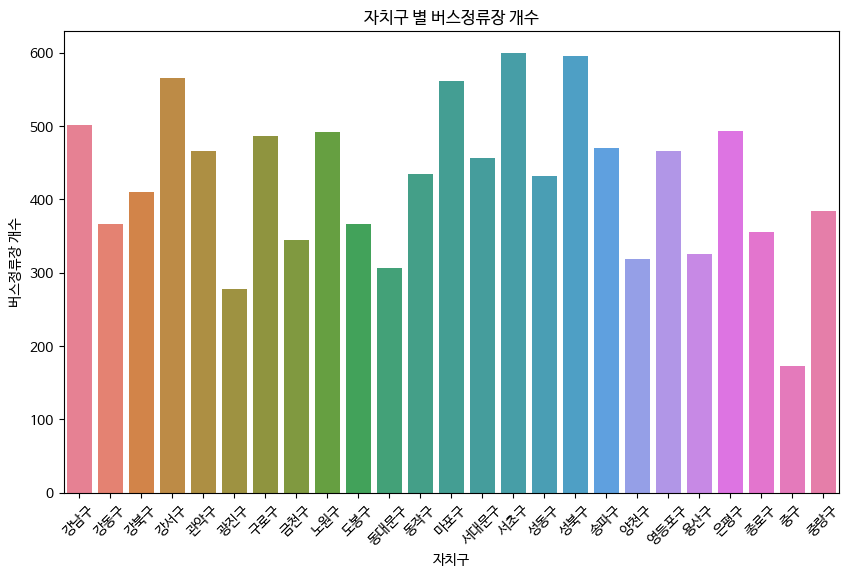

In [41]:
plt.figure(figsize = (10, 6))
sns.barplot(x = '자치구', y = '버스정류장ARS번호', data = bus_station_count, hue = '자치구')
plt.title('자치구 별 버스정류장 개수')
plt.ylabel('버스정류장 개수')
plt.xticks(rotation = 45)
plt.show()

In [19]:
in_out = bus_station.groupby('자치구', as_index = False)[['승차총승객수', '하차총승객수']].sum()

In [20]:
in_out['승하차비율'] = in_out['하차총승객수'] / in_out['승차총승객수']
in_out

,자치구,승차총승객수,하차총승객수,승하차비율
0,강남구,8578086,8104780,0.944824
1,강동구,3168847,3114908,0.982978
2,강북구,5148583,4977214,0.966715
3,강서구,4981166,4969176,0.997593
4,관악구,7656347,7832432,1.022999
5,광진구,3069933,3086696,1.005460
6,구로구,5298007,5096495,0.961965
7,금천구,3943538,3758365,0.953044
8,노원구,4628231,4555763,0.984342
9,도봉구,3513797,3447156,0.981034


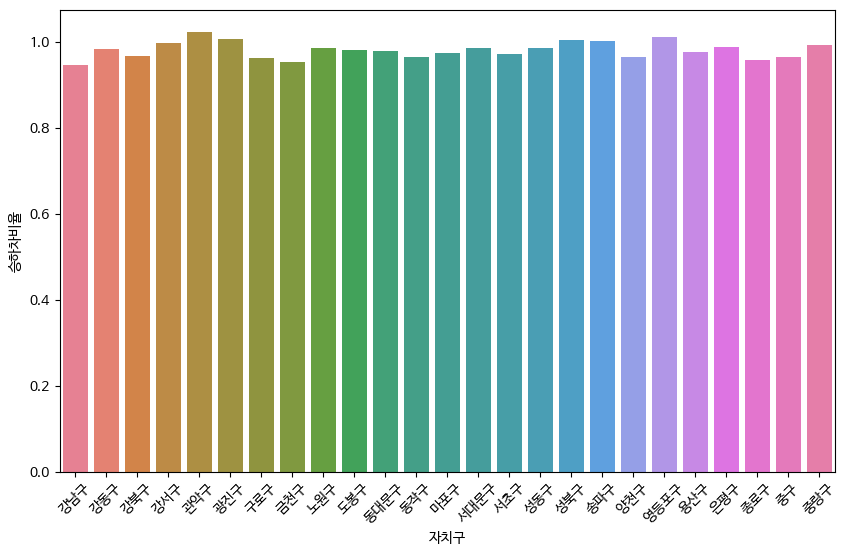

In [21]:
plt.figure(figsize = (10, 6))
sns.barplot(x = '자치구', y = '승하차비율', data = in_out, hue = '자치구')
plt.xticks(rotation = 45)
plt.show()

In [22]:
seoul = pd.read_excel('/content/drive/MyDrive/seoul_bus/서울시버스정류소위치정보(20240507).xlsx')

In [23]:
seoul.head()

,NODE_ID,ARS_ID,정류소명,X좌표,Y좌표,정류소타입
0,100000001,1001,종로2가사거리,126.987752,37.569806,중앙차로
1,100000002,1002,창경궁.서울대학교병원,126.996521,37.579433,중앙차로
2,100000003,1003,명륜3가.성대입구,126.998251,37.582580,중앙차로
3,100000004,1004,종로2가.삼일교,126.987613,37.568579,중앙차로
4,100000005,1005,혜화동로터리.여운형활동터,127.001744,37.586243,중앙차로


In [24]:
bus_list = list(set(bus_station['버스정류장ARS번호']) - set(seoul['ARS_ID']))
bus_list

[11287,
 5181,
 5182,
 21072,
 15450,
 15451,
 15452,
 15453,
 21082,
 14442,
 7817,
 7818,
 7819,
 7820,
 7821,
 7822,
 7827,
 7828,
 7829,
 7830,
 7831,
 7832,
 8354,
 11430,
 8397,
 6351,
 4835,
 8425,
 20717,
 20718,
 14065,
 14066,
 19705,
 19706,
 16635,
 13094,
 13096,
 20266,
 20267,
 13106,
 7476,
 13108,
 10046,
 7491,
 14148,
 7494,
 7495,
 7496,
 20295,
 7498,
 7499,
 18777,
 7516,
 7015,
 7016,
 7017,
 7018,
 7020,
 7021,
 8565,
 20349,
 7552,
 7553,
 7043,
 7045,
 7057,
 7058,
 7060,
 7587,
 7588,
 7592,
 7593,
 7594,
 7595,
 10170,
 7616,
 14305,
 14328,
 7674,
 7675]

In [25]:
bus_station[bus_station['버스정류장ARS번호'].isin(bus_list)]

,사용일자,노선번호,노선명,표준버스정류장ID,버스정류장ARS번호,역명,승차총승객수,하차총승객수,등록일자,자치구
197,20240401,7727,7727번(설문동~신촌),219000771,20717,고양실업고등학교(00104),0,34,20240404,동작구
198,20240401,7727,7727번(설문동~신촌),219000770,20718,고양실업고등학교(00005),27,0,20240404,동작구
216,20240401,7727,7727번(설문동~신촌),219000337,20295,부대앞.고양실업고교(00004),14,3,20240404,동작구
638,20240401,673,673번(상동기점~이대부고),277104252,15450,원종IC(경유)(00025),1,3,20240404,양천구
639,20240401,673,673번(상동기점~이대부고),277104251,15453,원종IC(경유)(00085),0,2,20240404,양천구
...,...,...,...,...,...,...,...,...,...,...
1217969,20240430,5634,5634번(광명공영차고지~여의도),213000455,14328,광명차고지(00001),56,1,20240503,마포구
1218387,20240430,774,774번(구파발역~파주읍),218000364,19705,힐스테이트삼송역(00142),39,36,20240503,영등포구
1221641,20240430,606,606번(부천상동~종로1가),210000363,11287,부천북부역농협(00016),231,73,20240503,노원구
1225001,20240430,502,502(월암공영차고지~한국은행신세계),209000030,10170,평촌동주민센터.KT동안양지점.대우아파트(00104),109,296,20240503,도봉구


## 서울버스이지만 경기도를 지나가는 버스들임
 - 버스정류장ARS번호가 서울시와 겹치게 되어있어서 자치구에 혼선을 빚게 되었다고 추정

 - 위 데이터들은 기본데이터에서 삭제하는게 맞다고 판단됨.

In [26]:
drop_cols = bus_station[bus_station['버스정류장ARS번호'].isin(bus_list)].index

bus_station = bus_station.drop(drop_cols, axis = 0)

In [27]:
#삭제된것 확인
bus_station[bus_station['버스정류장ARS번호'].isin(bus_list)]

,사용일자,노선번호,노선명,표준버스정류장ID,버스정류장ARS번호,역명,승차총승객수,하차총승객수,등록일자,자치구


In [28]:
seoul = seoul.rename(columns = {'ARS_ID' : '버스정류장ARS번호'})
seoul

,NODE_ID,버스정류장ARS번호,정류소명,X좌표,Y좌표,정류소타입
0,100000001,1001,종로2가사거리,126.987752,37.569806,중앙차로
1,100000002,1002,창경궁.서울대학교병원,126.996521,37.579433,중앙차로
2,100000003,1003,명륜3가.성대입구,126.998251,37.582580,중앙차로
3,100000004,1004,종로2가.삼일교,126.987613,37.568579,중앙차로
4,100000005,1005,혜화동로터리.여운형활동터,127.001744,37.586243,중앙차로
...,...,...,...,...,...,...
11256,124000334,25995,우성아파트,127.139339,37.550386,일반차로
11257,124000333,25996,우성아파트,127.140046,37.550643,일반차로
11258,124000332,25997,조일약국,127.123596,37.533630,일반차로
11259,124000331,25998,성내시장,127.125497,37.536155,일반차로


## 두 데이터프레임 병합

In [29]:
new_data = pd.merge(bus_station, seoul, on = '버스정류장ARS번호', how = "inner")
new_data

,사용일자,노선번호,노선명,표준버스정류장ID,버스정류장ARS번호,역명,승차총승객수,하차총승객수,등록일자,자치구,NODE_ID,정류소명,X좌표,Y좌표,정류소타입
0,20240401,100,100번(하계동~용산구청),100000002,1002,창경궁.서울대학교병원(00031),114,178,20240404,종로구,100000002,창경궁.서울대학교병원,126.996521,37.579433,중앙차로
1,20240401,107,107번(민락동차고지~동대문),100000002,1002,창경궁.서울대학교병원(00059),43,128,20240404,종로구,100000002,창경궁.서울대학교병원,126.996521,37.579433,중앙차로
2,20240401,8101,8101번(도봉보건소~서소문),100000002,1002,창경궁.서울대학교병원(00019),4,18,20240404,종로구,100000002,창경궁.서울대학교병원,126.996521,37.579433,중앙차로
3,20240401,162,162번(정릉~여의도),100000002,1002,창경궁.서울대학교병원(00015),223,228,20240404,종로구,100000002,창경궁.서울대학교병원,126.996521,37.579433,중앙차로
4,20240401,143,143번(정릉~개포동),100000002,1002,창경궁.서울대학교병원(00015),214,203,20240404,종로구,100000002,창경궁.서울대학교병원,126.996521,37.579433,중앙차로
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1125497,20240430,105,105번(상계동~서울역),101000335,2234,퇴계로2가.명동역7번출구(00042),68,520,20240503,중구,101000335,퇴계로2가.명동역7번출구,126.985336,37.560988,일반차로
1125498,20240430,463,463(염곡동~국회의사당),101000335,2234,퇴계로2가.명동역7번출구(00035),338,490,20240503,중구,101000335,퇴계로2가.명동역7번출구,126.985336,37.560988,일반차로
1125499,20240430,604,604번(신월동~중구청),101000335,2234,퇴계로2가.명동역7번출구(00049),289,61,20240503,중구,101000335,퇴계로2가.명동역7번출구,126.985336,37.560988,일반차로
1125500,20240428,9711,9711번(일산동부경찰서~양재역),118000557,19908,근로복지공단(가상)(00057),0,1,20240501,영등포구,118000557,근로복지공단(가상),126.916317,37.519999,가상정류장


In [30]:
bus_station_count = new_data.groupby('자치구')[['버스정류장ARS번호']].nunique()
bus_station_count

,버스정류장ARS번호
자치구,
강남구,501
강동구,367
강북구,410
강서구,565
관악구,466
광진구,278
구로구,486
금천구,345
노원구,492


In [31]:
#서울시 전체 버스정류장 개수

bus_station_count['버스정류장ARS번호'].sum()

10650

#### 구 별 버스노선 개수 확인

In [32]:
bus_line = new_data.groupby('자치구', as_index = False)[['노선번호']].nunique()
bus_line

,자치구,노선번호
0,강남구,98
1,강동구,23
2,강북구,71
3,강서구,52
4,관악구,81
5,광진구,43
6,구로구,81
7,금천구,56
8,노원구,59
9,도봉구,54


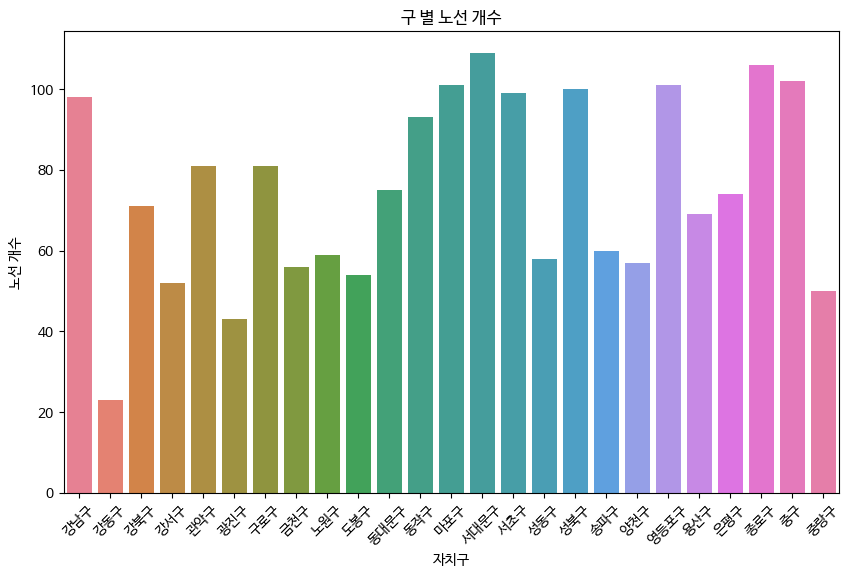

In [33]:
plt.figure(figsize = (10, 6))

sns.barplot(x = '자치구', y = '노선번호', hue = '자치구', data = bus_line)

plt.title('구 별 노선 개수')
plt.xlabel('자치구')
plt.ylabel('노선 개수')

plt.xticks(rotation = 45)
plt.show()

- 강동구, 광진구 중랑구를 지나는 버스 노선이 현저히 적다는것을 알 수 있다.

#### 승차 총 승객수, 하차 총 승객수, 승/하차 평균 승객수 데이터프레임 생성

In [34]:
in_out = new_data.groupby('자치구', as_index = False)[['승차총승객수', '하차총승객수']].sum()
in_out_mean = new_data.groupby('자치구', as_index = False)[['승차총승객수', '하차총승객수']].mean()
in_out_mean = in_out_mean.rename(columns = {'승차총승객수' : '승차평균승객수', '하차총승객수' : '하차평균승객수'})
in_out_mean

,자치구,승차평균승객수,하차평균승객수
0,강남구,129.996605,122.823890
1,강동구,96.714390,95.068152
2,강북구,138.600237,133.986971
3,강서구,91.697641,91.453123
4,관악구,151.365711,154.737920
5,광진구,117.548671,118.180554
6,구로구,123.378752,118.685988
7,금천구,130.612809,125.494918
8,노원구,91.981463,90.686924
9,도봉구,110.323116,107.697856


In [35]:
df = pd.merge(bus_station_count, bus_line, on = '자치구', how = 'inner')
df = pd.merge(df, in_out, on = '자치구', how = 'inner')
df = pd.merge(df, in_out_mean, on = '자치구', how = 'inner')
df = df.rename(columns = {'버스정류장ARS번호' : '정류장수', '노선번호':'노선수'})
df

,자치구,정류장수,노선수,승차총승객수,하차총승객수,승차평균승객수,하차평균승객수
0,강남구,501,98,8578086,8104780,129.996605,122.823890
1,강동구,367,23,3168847,3114908,96.714390,95.068152
2,강북구,410,71,5148583,4977214,138.600237,133.986971
3,강서구,565,52,4976431,4963161,91.697641,91.453123
4,관악구,466,81,7640487,7810706,151.365711,154.737920
5,광진구,278,43,3069666,3086167,117.548671,118.180554
6,구로구,486,81,5298007,5096495,123.378752,118.685988
7,금천구,345,56,3881029,3728956,130.612809,125.494918
8,노원구,492,59,4614710,4549763,91.981463,90.686924
9,도봉구,366,54,3498346,3415099,110.323116,107.697856


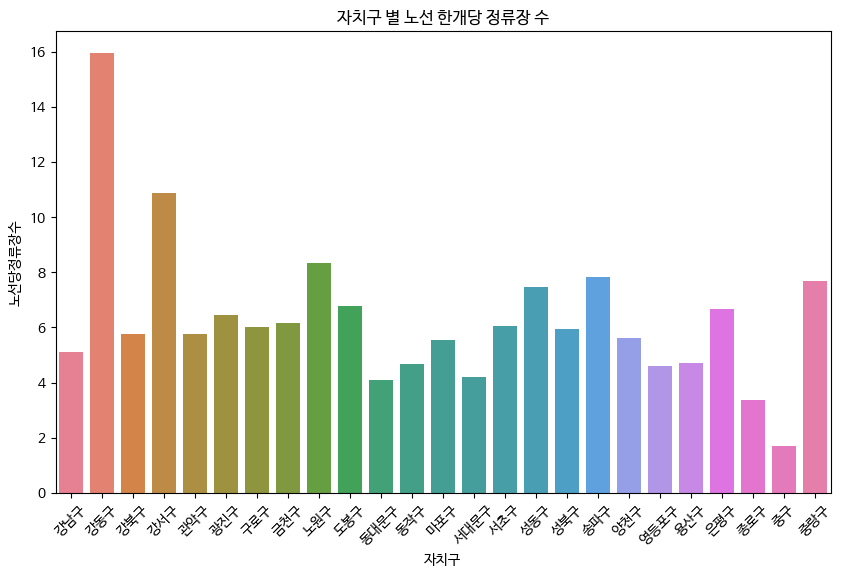

In [57]:
## 정류장수 / 노선수 숫자 크면 한 노선이 감당하는 정류장 수가 많다.
df['노선당정류장수'] = df['정류장수'] / df['노선수']
plt.figure(figsize = (10, 6))
sns.barplot(x = '자치구', y = '노선당정류장수', hue = '자치구', data = df)
plt.title('자치구 별 노선 한개당 정류장 수')
plt.xticks(rotation = 45)
plt.show()

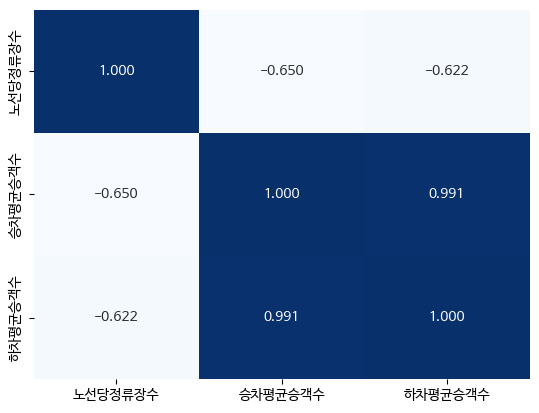

In [63]:
cols = ['노선당정류장수', '승차평균승객수', '하차평균승객수']
df_corr = df[cols].corr()
sns.heatmap(df_corr,
            annot = True,
            fmt = '.3f',
            cbar = False,
            cmap = 'Blues')
plt.show()

In [62]:
print('노선당정류장수와 승차 총 승객수 상관관계:', spst.pearsonr(df['노선당정류장수'], df['승차평균승객수']))
print('노선당정류장수와 하차 총 승객수 상관관계:', spst.pearsonr(df['노선당정류장수'], df['하차평균승객수']))

노선당정류장수와 승차 총 승객수 상관관계: PearsonRResult(statistic=-0.6499453321802389, pvalue=0.00043714683508796294)
노선당정류장수와 하차 총 승객수 상관관계: PearsonRResult(statistic=-0.6224689996569558, pvalue=0.0008911186172940391)


#### 위에서 자치구별 정류장수, 승하차 수 시각화 그래프를 통해 확인

[단변량 분석 시행]

In [60]:
#기초적인 통계량 확인

df.describe()

,정류장수,노선수,승차총승객수,하차총승객수,승차평균승객수,하차평균승객수,노선별정류장비율,노선당정류장수
count,25.000000,25.000000,2.500000e+01,2.500000e+01,25.000000,25.000000,25.000000,25.000000
mean,426.000000,74.880000,5.338048e+06,5.235468e+06,119.047748,116.702627,6.294025,6.294025
std,104.647424,23.411749,1.489391e+06,1.465462e+06,18.706757,18.206474,2.697989,2.697989
min,173.000000,23.000000,3.066287e+06,3.030551e+06,85.096987,84.045739,1.696078,1.696078
25%,356.000000,57.000000,4.311593e+06,4.152994e+06,104.983708,102.535527,4.724638,4.724638
50%,435.000000,74.000000,5.298007e+06,5.096495e+06,123.378752,119.499663,5.950000,5.950000
75%,492.000000,99.000000,6.223305e+06,6.033701e+06,130.612809,126.952634,6.777778,6.777778
max,600.000000,109.000000,8.578086e+06,8.104780e+06,151.365711,154.737920,15.956522,15.956522


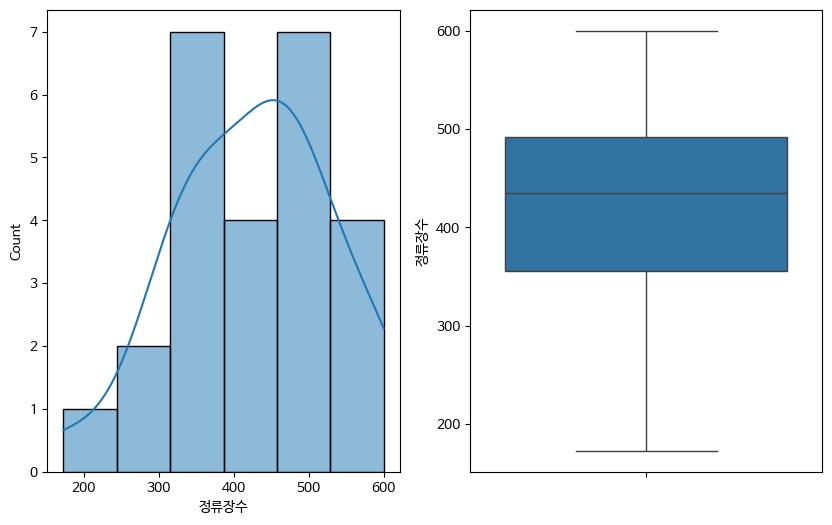

In [37]:
plt.figure(figsize = (10,6))

plt.subplot(1,2,1)
sns.histplot(df['정류장수'], kde = True)

plt.subplot(1,2,2)
sns.boxplot(df['정류장수'])
plt.show()

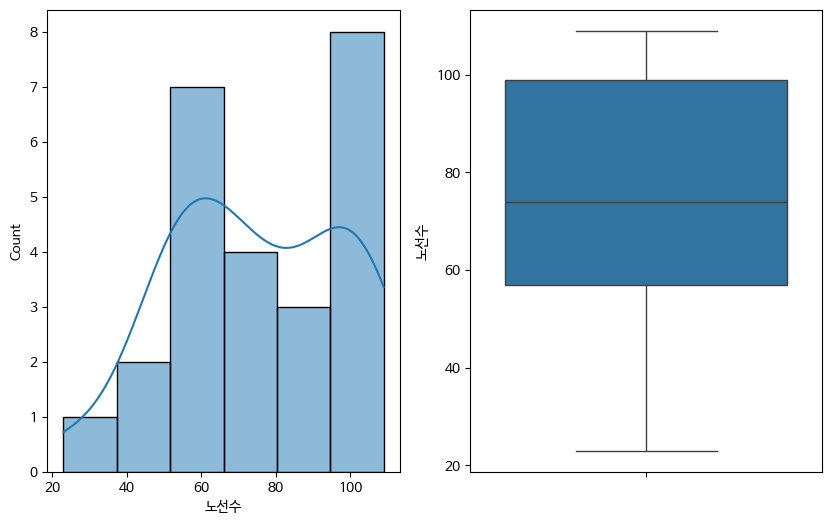

In [38]:
plt.figure(figsize = (10,6))

plt.subplot(1,2,1)
sns.histplot(df['노선수'], kde = True)

plt.subplot(1,2,2)
sns.boxplot(df['노선수'])
plt.show()

- 승/하차 총승객수나 평균 승객수는 큰 차이를 보이지 않음 -> 특정한 자치구에서 승차하거나 하차하는 상황은 많지 않다.

- 노선수와 정류장수에서도 이상치는 발견되지 않았음. 하지만 자치구 별로 정류장수와 노선수의 차이는 있다고 판단됨

[이변량 분석 시행]

- 정류장수와 승/하차평균승객수 비교
- 노선수와 승/하차 평균 승객수 비교

In [44]:
cols = ['노선수', '승차총승객수', '하차총승객수']
df_corr = df[cols].corr()

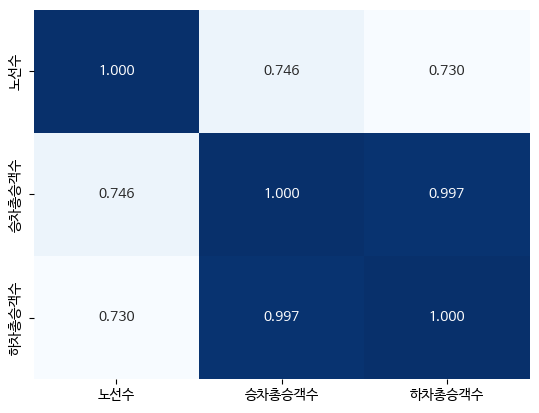

In [47]:
sns.heatmap(df_corr,
            annot = True,
            fmt = '.3f',
            cbar = False,
            cmap = 'Blues')
plt.show()

In [49]:
cols = ['정류장수', '승차총승객수', '하차총승객수']
df_corr = df[cols].corr()

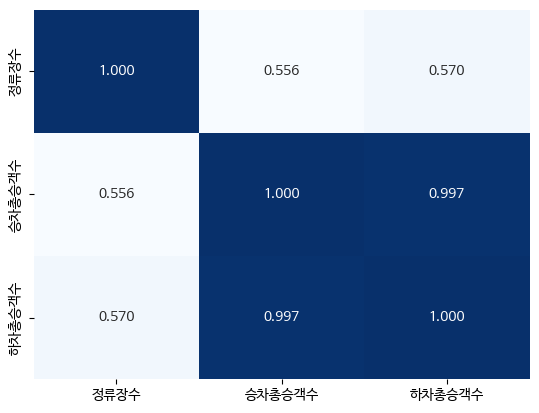

In [50]:
sns.heatmap(df_corr,
            annot = True,
            fmt = '.3f',
            cbar = False,
            cmap = 'Blues')
plt.show()

In [48]:
print('노선수와 승차 총 승객수 상관관계:', spst.pearsonr(df['노선수'], df['승차총승객수']))
print('노선수와 하차 총 승객수 상관관계:', spst.pearsonr(df['노선수'], df['하차총승객수']))

노선수와 승차 총 승객수 상관관계: PearsonRResult(statistic=0.7460863525469438, pvalue=1.8546723754418923e-05)
노선수와 하차 총 승객수 상관관계: PearsonRResult(statistic=0.7304922829015824, pvalue=3.3817326193143465e-05)


In [51]:
print('정류장수와 승차 총 승객수 상관관계:', spst.pearsonr(df['정류장수'], df['승차총승객수']))
print('정류장수와 하차 총 승객수 상관관계:', spst.pearsonr(df['정류장수'], df['하차총승객수']))

정류장수와 승차 총 승객수 상관관계: PearsonRResult(statistic=0.5558974022738388, pvalue=0.0039107671145858095)
정류장수와 하차 총 승객수 상관관계: PearsonRResult(statistic=0.5698172393395182, pvalue=0.0029441449291157168)


- 상관계수를 확인해오변 노선수와 승/하차인원과는 상관관계에 있다고 할 수 있다.
- 정류장수와 승/하차 승객수는 상관관계가 없다!

In [42]:
## 정류장수와 노선수의 상관관계

print('정류장수와 노선수의 상관관계:', spst.pearsonr(df['정류장수'], df['노선수']))

정류장수와 노선수의 상관관계: PearsonRResult(statistic=0.2826044352350187, pvalue=0.1710700077624312)


- 정류장 수와 노선수는 상관관계가 없다고 할 수 있다.
- p-value > 0.1, 상관계수 0.28